# Expectation Maximisation: coin flips

This example is based on the paper *[What is the expectation maximization
algorithm?](https://www.nature.com/nbt/journal/v26/n8/pdf/nbt1406.pdf)* by Do & Batzoglou.

## Setup

Suppose we have two coins, A and B. Suppose also that we have the following sequences of coin flips, generated by flipping each coin labelled A or B a number of times:

In [1]:
# N.B. each coin label in `labels` corresponds to the sequence of flips at the same index in `flip_seqs`

labels = ['B', 'A', 'A', 'B', 'A']

flip_seqs = ['HTTTHHTHHHTTHHHHHT',
             'HHTHHHHHTTTTTTTTT',
             'HTHHHHTTHHTTTTTTTTTTTTTTTT',
             'HTHTTTTTTHHHHHTHHHHHHHHHHHHHHHHHHTTTT',
             'THHHTHHHTHTTTTTTTTTT']

## Probability of heads

Call the probability of a coin landing heads $\theta$. This parameter may be $0.5$ (a fair coin), or it could be higher (more heads), or lower (fewer heads).

We can estimate this parameter for each coin separately from our data using the formula

$$\theta = \frac{H}{H+T}$$

where $H$ is the total number of heads and $T$ is the total number of tails seen across the flip sequences for each coin. Here's a Python function to do exactly this:

In [2]:
def estimate_theta(H, T):
    """
    Fraction of heads given H heads and T tails.
    """
    return H / (H + T)

Very simple. To use it, we just need to count the number of heads and tails across the sequences for each of the labels A and B.

In [3]:
from collections import Counter, defaultdict

count_dict = defaultdict(Counter)

for label, seq in zip(labels, flip_seqs):
    count_dict[label] += Counter(seq)
    
print('Coin label A: there were {H} heads and {T} tails across the flip sequences'.format(**count_dict['A']))
print('Coin label B: there were {H} heads and {T} tails across the flip sequences'.format(**count_dict['B']))

Coin label A: there were 21 heads and 42 tails across the flip sequences
Coin label B: there were 36 heads and 19 tails across the flip sequences


So we estimate $\theta_A$ to be:

In [4]:
estimate_theta(**count_dict['A'])

0.3333333333333333

And we estimate $\theta_B$ to be:

In [5]:
estimate_theta(**count_dict['B'])

0.6545454545454545

## Likelihood functions

The values above are the **maximum likelihood** estimates for $\theta_A$ and $\theta_B$. They are the values that are most likely to produce the counts of heads and tails we observed for each coin. They maximise the **likelihood function** for A and for B (no other input value to the function would yield a greater output).

What is a likelihood function? It tells you, given some data and a parameter, how well the parameter fits the data. In other words, how likely the parameter is be "correct".

What is the likelihood function in this coin flip example?

Recall that the [binomial formula](https://en.wikipedia.org/wiki/Binomial_distribution#Probability_mass_function) computes the probability that we have $H$ successes in $H+T$ independent trials, where the proability of success is $\theta$:

$$p(H,T  \mid \theta)=\left({H+T \atop H}\right) \theta^H (1-\theta)^T$$

By [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) we can also use this formula to compute the probability of $\theta$ given $H$ heads and $T$ tails, i.e. $p(\theta \mid H, T) = p(H,T  \mid \theta) \cdot k$.

We're making the assumption here that $k$ is constant because it is reasonable to treat $p(\theta)$ as constant (prior to the experiment we think one possible value of $\theta$ is just as probable as another for our coin). For our purpose, it does not matter what constant value is it.

Unlike a probability function, a likelihood function does not need to produce a value between 0 and 1. All we're interested in here is making it as large as possible for our choice of $\theta$ which means we can just ignore constant multipliers like $k$ and $\left({H+T \atop H}\right)$.

So the likelihood of $\theta$, given we saw $H$ heads and $T$ tails can just be expressed as

$$\ell(\theta \mid H, T)=\theta^H (1-\theta)^{T}$$

Here's a Python function to compute the likelihood of $\theta$:

In [6]:
def likelihood_of_theta(theta, H, T):
    """
    Likelihood of theta, given that we saw H heads and T tails.
    """
    return theta**H * (1 - theta)**T

If we plot $\ell(\theta \mid H, T)$ for all values of $\theta$ between 0 and 1, we can see verfiy that $\frac{H}{H+T}$ does indeed give find the value of $\theta$ that produces the maximum likelihood (the dotted line):

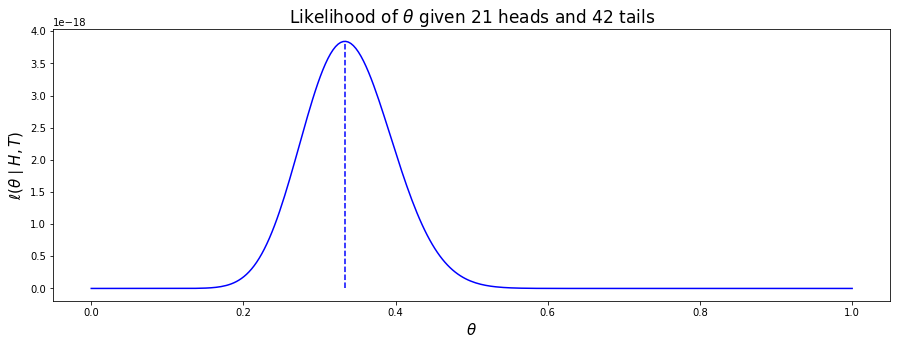

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

counts = count_dict['A']

H = counts['H']
T = counts['T']

theta = np.linspace(0, 1, 300)
theta_likelihood = likelihood_of_theta(theta, H, T)

# maximum likelihood estimate
m = estimate_theta(H, T)
m_likelihood = likelihood_of_theta(m, H, T)

# plotting 
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(theta, theta_likelihood, color='b');
plt.vlines(m, 0, m_likelihood, 'b', '--');
plt.title(r'Likelihood of $\theta$ given {} heads and {} tails'.format(H, T), fontsize=17);
plt.ylabel(r'$\ell(\theta \mid H,T)$', fontsize=15);
plt.xlabel(r'$\theta$', fontsize=15);

*N.B. curve may no be drawn completely accurately if values for $H$ or $T$ are large, given limited precision of floating-point values.*

If you want to read more about switching from $p(\theta \mid H, T)$ to $p(H,T  \mid \theta)$ (and the connection with the Beta distribution which I did not mention above) you may find he short blog post [Bayesian inference for a binomial proportion](https://stephens999.github.io/fiveMinuteStats/bayes_beta_binomial.html) by Matthew Stephens helpful.

## Hidden labels!

What if we want to recover the values $\theta_A$ and $\theta_B$, but we only know what the sequences of flips are, *not* the label of the coin that produced each sequence?

In other words, we know that we have two coins and that they have been flipped to produce these sequences of flips: 

In [8]:
print(*flip_seqs, sep='\n')

HTTTHHTHHHTTHHHHHT
HHTHHHHHTTTTTTTTT
HTHHHHTTHHTTTTTTTTTTTTTTTT
HTHTTTTTTHHHHHTHHHHHHHHHHHHHHHHHHTTTT
THHHTHHHTHTTTTTTTTTT


...but the label of each coin is a *hidden variable*. 

The function `estimate_theta()` is now unable to produce our maximum likelihood estimates for $\theta_A$ and $\theta_B$ because as we do not know the true counts of heads and tails for each coin.

## Expectation Maximisation

All is not lost. We can use **Expectation Maximisation** (EM) to estimate the parameter values that are most likely to produce the data we have observed. 

This method is not guaranteed to produce the same values we'd derive if we *could* see the labels, but it may get us very close.

There are essentially five steps:

1. Start with initial estimates of $\theta_A$ and $\theta_B$ (these can be anything).
2. Check how likely each estimate is to produce each sequence of coin flips (using our likelihood function).
3. Produce a weighting for each parameter for each sequence: in other words, the greater the weighting the more we believe the to have been generated by the parameter. Adjust the counts of heads and tails by multiplying them by the weighting (the **Expectation** step). 

4. For A and B, add up the total number of weighted counts for heads and tails across all sequences (call these counts $H'$ and $T'$). Produce new estimates for $\theta_A$ and $\theta_B$ using the maximum likelihood formula $\frac{H'}{H' + T'}$ (the **Maximisation** step).

5. Repeat steps 2-4 until each parameter estimate has converged, or a set number of iterations has been reached.


The function to re-weight the counts of heads and tails looks like this:

In [9]:
def expected_counts(counter, weight):
    """
    Adjust the counts in the counter dictionary
    by multiplying them by a weight value.
    
    N.B. counts may not be integer values after
    weighting is applied.
    """
    return Counter({k: v*weight for k, v in counter.items()})

Now we can run EM and see what estimates the algorith finishes with:

In [10]:
# count the number of heads and tails in each sequence of coin flips
counts_for_seqs = [Counter(seq) for seq in flip_seqs]

# 1. Make initial estimates for each parameter
theta_A = 0.51
theta_B = 0.001

ITER = 10 # number of iterations to run EM for

for index in range(0, ITER+1):
    
    print('{}\ttheta_A: {:.5f}\ttheta_B: {:.5f}'.format(index, theta_A, theta_B))
      
    ## Expectation step
    ## ----------------
    
    # 2. How likely are the current estimates of theta to produce H heads and T tails for each sequence?
    l_A = [likelihood_of_theta(theta_A, **counts) for counts in counts_for_seqs]
    l_B = [likelihood_of_theta(theta_B, **counts) for counts in counts_for_seqs]
    
    # 3. Normalise these likelihoods so that they sum to 1, call them 'weights'
    weight_A = [a / (a+b) for a, b in zip(l_A, l_B)]
    weight_B = [b / (a+b) for a, b in zip(l_A, l_B)]
    
    # expected counts of heads/tails for sequences of coin flips given weights
    exp_counts_A = [expected_counts(counts, w) for counts, w in zip(counts_for_seqs, weight_A)]
    exp_counts_B = [expected_counts(counts, w) for counts, w in zip(counts_for_seqs, weight_B)]
    
    ## Maximisation step
    ## -----------------
    
    # 4. Find total number of heads/tails across the sequences of coin flips
    total_A = sum(exp_counts_A, Counter())
    total_B = sum(exp_counts_B, Counter())
        
    # compute new parameter estimates for theta
    theta_A = estimate_theta(**total_A)
    theta_B = estimate_theta(**total_B)

0	theta_A: 0.51000	theta_B: 0.00100
1	theta_A: 0.48305	theta_B: 0.27024
2	theta_A: 0.57712	theta_B: 0.31496
3	theta_A: 0.61916	theta_B: 0.32748
4	theta_A: 0.63382	theta_B: 0.33192
5	theta_A: 0.63813	theta_B: 0.33340
6	theta_A: 0.63932	theta_B: 0.33385
7	theta_A: 0.63964	theta_B: 0.33398
8	theta_A: 0.63973	theta_B: 0.33402
9	theta_A: 0.63975	theta_B: 0.33403
10	theta_A: 0.63976	theta_B: 0.33403


We see that the guesses for each paramter converge after only a few iterations. Compare these guesses with the maximum likelihood estimates made when we *did* know the label for each sequence of coin flips:

In [11]:
from IPython.display import Markdown

actual_A = estimate_theta(**count_dict['A'])
actual_B = estimate_theta(**count_dict['B'])

md = r"""
|            | Actual         | EM estimate   |
| ---------- |:---------------| :------------ |
| $\theta_A$ | {actual_A:.5f} | {em_A:.5f}    |
| $\theta_B$ | {actual_B:.5f} | {em_B:.5f}    |
"""

Markdown(
    md.format(
        actual_A=actual_A,
        actual_B=actual_B,
        em_A=theta_A,
        em_B=theta_B,
    )
)


|            | Actual         | EM estimate   |
| ---------- |:---------------| :------------ |
| $\theta_A$ | 0.33333 | 0.63976    |
| $\theta_B$ | 0.65455 | 0.33403    |


You might notice that the estimates for the coins appear to have been switched around. This sometimes happens and can depend on the intial guesses for the parameters. This is because EM has no opinion about which coin has which parameter here, just the most likely values of the parameters.